<a href="https://colab.research.google.com/github/tarek3laa/dogs_vs_cats_Classification/blob/master/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import libiares**

In [103]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import layers as L, Sequential,optimizers,losses
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint,Callback,ReduceLROnPlateau
from keras import backend as K
import os
import cv2

**Download Data**

In [4]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 92% 249M/271M [00:04<00:00, 74.5MB/s]
100% 271M/271M [00:05<00:00, 56.5MB/s]
 98% 532M/544M [00:06<00:00, 83.1MB/s]
100% 544M/544M [00:06<00:00, 90.1MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 97.3MB/s]


In [5]:
!unzip train.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/552.jpg            
  inflating: test/5520.jpg           

In [6]:
!rm test.zip
!rm train.zip

**loading and exploring dataset**

In [104]:
def load_data():
  path_train = '/content/train'
  path_test = '/content/test'

  images_train = os.listdir(path_train)
  images_test = os.listdir(path_test)

  loadedImages_train = []
  label = []
  loadedImages_test = []
  id = []
  for image in images_train:
        img = cv2.imread(path_train+ '/'+image)
        img = cv2.resize(img,(65,65)) 
        loadedImages_train.append(img)
        if image[0:3]=='dog':
              label.append(1)
        else:
              label.append(0)
  for image in images_test:
    img = cv2.imread(path_test+ '/'+image)
    img = cv2.resize(img,(65,65)) 
    loadedImages_test.append(img)
    id.append(image.split('.')[0])

  X = np.array(loadedImages_train)
  y = np.array(label)
  X_test = np.array(loadedImages_test)
  id = np.array(id) 
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,shuffle = True)
  return X_train, X_val, y_train, y_val, X_test,id

In [105]:
X_train, X_val, y_train, y_val, X_test,id = load_data()

In [106]:
print("X_train shape: %s" % (str(X_train.shape)))
print("y_train shape: %s" % (str(y_train.shape)))

print("X_val shape: %s" % (str(X_val.shape)))
print("y_val shape: %s" % (str(y_val.shape)))

X_train shape: (18750, 65, 65, 3)
y_train shape: (18750,)
X_val shape: (6250, 65, 65, 3)
y_val shape: (6250,)


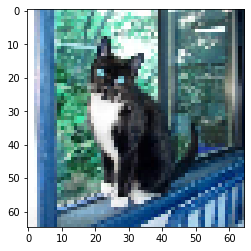

In [107]:
plt.imshow(X_train[90])

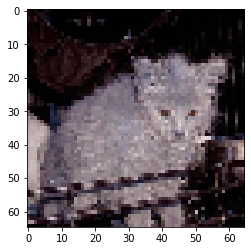

In [108]:
plt.imshow(X_train[50])

**Preparing Images**

In [109]:
train_gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                                shear_range=0.1,
                                height_shift_range=0.1, 
                                zoom_range=0.2,
                                horizontal_flip=True,
                                samplewise_center=True,
                                samplewise_std_normalization= True)

val_gen = ImageDataGenerator(samplewise_center=True,
                            samplewise_std_normalization= True)

val_gen.fit(ImageDataGenerator().flow(X_train, y_train, batch_size=100,shuffle=True).next()[0])

batches = train_gen.flow(X_train, y_train, batch_size=64)
val_batches = val_gen.flow(X_val, y_val, batch_size=64)
test_bat = val_gen.flow(X_test,batch_size=64,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


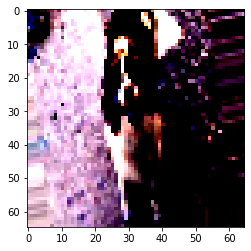

In [110]:
x, y = batches.__getitem__(3)
print(y[20])
plt.imshow(x[20])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


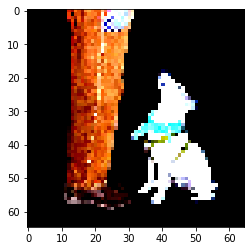

In [111]:
x, y = val_batches.__getitem__(3)
print(y[20])
plt.imshow(x[20])

**Define the model**

In [112]:
base_model = VGG16(include_top=False,weights="imagenet",input_shape=(65,65,3))

In [113]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 65, 65, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 65, 65, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 65, 65, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [114]:
#base_model.trainable = False
for layer in base_model.layers:
   layer.trainable = False

In [115]:
def get_model():
  model = Sequential()
  model.add(base_model.layers[0])
  for layer in base_model.layers[1:]:
      model.add(layer)
      model.add(L.BatchNormalization())
  model.add(L.Flatten())
  model.add(L.Dense(512,activation='relu'))
  model.add(L.Dropout(0.25))
  model.add(L.Dense(1024,activation='relu'))
  model.add(L.Dropout(0.25))
  model.add(L.Dense(1,activation='sigmoid'))
  return model

In [116]:
model = get_model()

In [117]:
INIT_LR = 9e-5
model.compile(optimizer=optimizers.adamax(INIT_LR), loss=losses.binary_crossentropy,
              metrics=['accuracy'])

In [118]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 65, 65, 64)        1792      
_________________________________________________________________
batch_normalization_109 (Bat (None, 65, 65, 64)        256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 65, 65, 64)        36928     
_________________________________________________________________
batch_normalization_110 (Bat (None, 65, 65, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_111 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)      

**Training**

In [119]:
lr_reduction =  ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=4,
    verbose=1,
    mode="auto",
    min_lr=0.000001)

# callback for printing of actual learning rate used by optimizer
class LrHistory(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [120]:
check_point = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/dogs_vs_cats/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',monitor ='loss',save_best_only=True)

In [100]:
history = model.fit(batches,epochs=10,validation_data=val_batches,callbacks=[check_point,
                                                                             lr_reduction,
                                                                             LrHistory()
                                                                             ])

Epoch 1/10
Learning rate: 9e-05
293/293 [==============================] - 88s 302ms/step - loss: 0.0954 - accuracy: 0.9645 - val_loss: 0.0335 - val_accuracy: 0.9723
Epoch 2/10
Learning rate: 9e-05
293/293 [==============================] - 83s 285ms/step - loss: 0.0905 - accuracy: 0.9664 - val_loss: 0.0440 - val_accuracy: 0.9709
Epoch 3/10
Learning rate: 9e-05
293/293 [==============================] - 84s 285ms/step - loss: 0.0912 - accuracy: 0.9647 - val_loss: 0.2888 - val_accuracy: 0.9715
Epoch 4/10
Learning rate: 9e-05
293/293 [==============================] - 84s 285ms/step - loss: 0.0884 - accuracy: 0.9645 - val_loss: 0.0542 - val_accuracy: 0.9712
Epoch 5/10
Learning rate: 9e-05
293/293 [==============================] - 84s 285ms/step - loss: 0.0878 - accuracy: 0.9657 - val_loss: 0.0541 - val_accuracy: 0.9712

Epoch 00005: ReduceLROnPlateau reducing learning rate to 7.200000109151006e-05.
Epoch 6/10
Learning rate: 7.2e-05
293/293 [==============================] - 84s 285ms/st

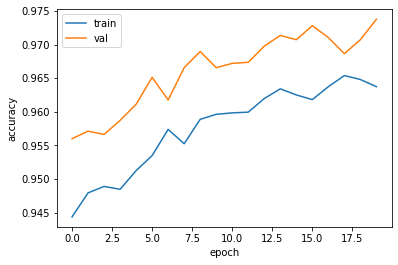

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')

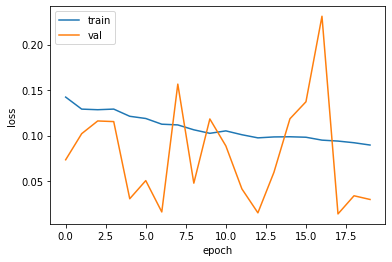

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')

In [121]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/dogs_vs_cats/ep005-loss0.088-val_loss0.177.h5')

In [101]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/dogs_vs_cats/final_weights.h5")

In [122]:
model.evaluate(val_batches)

98/98 [==============================] - 10s 103ms/step


[0.07968791574239731, 0.9668800234794617]

In [52]:
predictions = model.predict(test_bat).reshape(-1).tolist()

In [53]:
submissions=pd.DataFrame({"id": id,
                         "label": predictions})
submissions.sort_values(by=['id'],inplace=True)
submissions.to_csv("dog__vs__cats.csv", index=False, header=True)

!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f dog__vs__cats.csv -m "Message"

100% 297k/297k [00:04<00:00, 71.2kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition